In [1]:
import torch
import pathlib

from typing import List, Optional, Dict
from torch.autograd import Variable
from scipy.optimize import minimize
from collections import deque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Nile Data')

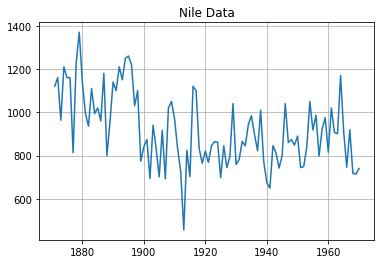

In [2]:
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

nile_dates = pd.read_csv(nile_path).index
nile_data = pd.read_csv(nile_path).values

fig, ax = plt.subplots()
ax.plot(range(1871, 1871 + len(nile_data)), nile_data)
ax.grid()
ax.set_title('Nile Data')

In [3]:
def _mm3(M1: torch.tensor, M2: torch.tensor, M3: torch.tensor):
    """
    compute matrix product of 3 matrices
    """
    return torch.mm(torch.mm(M1, M2), M3).type(dtype)

In [4]:
def _bmm3(M1: torch.tensor, M2: torch.tensor, M3: torch.tensor):
    """
    compute batch matrix product of 3 matrices
    """
    return torch.bmm(torch.bmm(M1, M2), M3).type(dtype)

In [5]:
def _initiate_variables(p: int, s: int, n: int, dtype=torch.float64):
    return torch.zeros(p, 1, n).type(dtype), torch.zeros(p, 1, n).type(dtype), torch.zeros(p, p, n).type(dtype), torch.zeros(p, p, n).type(dtype), torch.zeros(s, 1, n).type(dtype), torch.zeros(s, s, n).type(dtype), torch.zeros(p, s, n).type(dtype), torch.zeros(p, s, n).type(dtype)

In [6]:
def _map_vector_to_matrices(params, param_map, *args):
    
    T, Z, R, Q, H = args

    for k, v in param_map.items():

        state_matrix_asstr = v[0]
        i, j, t = v[1]
        constant_through_time = v[2]

        if state_matrix_asstr == "Q":
            Q[i, j] = float(params[k])
        if state_matrix_asstr == "H":
            H[i, j] = float(params[k])
        if state_matrix_asstr == "T":
            T[i, j] = float(params[k])
        if state_matrix_asstr == "Z":
            Z[i, j] = float(params[k])
        if state_matrix_asstr == "R":
            R[i, j] = float(params[k])
    
    return T.type(dtype), Z.type(dtype), R.type(dtype), Q.type(dtype), H.type(dtype)

In [7]:
def _get_nan_positions(y: torch.Tensor) -> List[int]:
        '''
        Find positions of nan elements for the Kalman filter

                Parameters:
                        y (np.Array[float])     : Observed time series which might contain NaN

                Returns:
                        nan_pos_list (List[int]): List of NaN positions
        '''

        if y.ndim > 1:
            y = np.squeeze(y)

        nan_pos_list = np.squeeze(np.argwhere(np.isnan(y))).tolist()

        return nan_pos_list

In [8]:
def _remove_nan_tensor(tensor):
    tensor = tensor.permute(2, 0, 1)
    return tensor[~torch.any(tensor.isnan(), dim=1)][:, :, None].permute(1,2,0)

def _remove_inf_tensor(tensor):
    tensor = tensor.permute(2, 0, 1)
    return tensor[~torch.any(tensor.isinf(), dim=1)][:, :, None].permute(1,2,0)

In [9]:
# Will be forward method

def _kalman_step(T, Z, R, Q, H, a, P, y):
    """
    perform 1 step of the kalman filter
    """
    
    # prediction error: v
    v = y - torch.mm(Z, a)
    
    # prediction error variance: F
    F = _mm3(Z, P, Z.t()) + H
    
    # incast-kalman gain: M
    M = _mm3(P, Z.t(), torch.inverse(F)) 
    
    # kalman gain: K
    K = torch.mm(T, M)
    
    # incasted updates
    att = a + torch.mm(M, v)
    Ptt = P - _mm3(M, F, M.t())
    
    a_next = torch.mm(T, att)
    P_next = _mm3(T, Ptt, T.t()) + _mm3(R, Q, R.t())
    
    return a_next, P_next, att, Ptt, M, K, F, v

In [10]:
# Will be forward method

def _kalman_step_missing(T, Z, R, Q, H, a, P, y, dtype=torch.float64):
    """
    perform 1 step of the kalman filter when observation is missing
    """
    
    # dimension of observation vector
    s = int(y.shape[0])
    
    # prediction error: v
    v = torch.nan
    
    if s==1:
        F = torch.Tensor([[torch.inf]]).type(dtype)
    else:
        # prediction error variance: F
        F = torch.eye(s).type(dtype) * torch.inf
    
    # incast-kalman gain: M
    M = _mm3(P, Z.t(), torch.inverse(F).type(dtype)) 
    
    # kalman gain: K
    K = torch.zeros_like(torch.mm(T, M))
    
    # incasted updates
    att = a
    Ptt = P
    
    a_next = torch.mm(T, att)
    P_next = _mm3(T, Ptt, T.t()) + _mm3(R, Q, R.t())
    
    return a_next, P_next, att, Ptt, M, K, F, v

In [11]:
def kalman_filter(*args, diffuse=False):
    """
    perform all the steps of the Kalman filter
    """
    T, Z, R, Q, H, y = args
    
    # number of observations
    n = int(y.shape[2])
    
    # dimension of state vector
    p = int(T.shape[0])
    
    # dimension of observation vector
    s = int(y.shape[0])
    
    # initiate filters (a, att), filter variances (P, Ptt), errors (v), error variances (F), and Kalman gains (K, M)
    a, att, P, Ptt, v, F, K, M = _initiate_variables(p, s, n)
    
    # get positions of missing observations
    nan_pos_list = _get_nan_positions(y)
    
    # do a diffuse initialization
    if diffuse:
        a[:, :, 0] = 0
        P[:, :, 0] = P[:, :, 0] + 1e5 * torch.eye(p, p)

    # iterate through time
    for t in range(1, n):
        
        if t-1 not in nan_pos_list:
            # a[0] contains a1, y[0] contains y1
            y_t = y[:, :, t-1]
            a[:, :, t], P[:, :, t], att[:, :, t-1], Ptt[:, :, t-1], M[:, :, t-1], K[:, :, t-1], F[:, :, t-1], v[:, :, t-1] = _kalman_step(T, Z, R, Q, H, a[:, :, t-1], P[:, :, t-1], y_t)
        
        else:
            y_t = y[:, :, t-1]
            a[:, :, t], P[:, :, t], att[:, :, t-1], Ptt[:, :, t-1], M[:, :, t-1], K[:, :, t-1], F[:, :, t-1], v[:, :, t-1] = _kalman_step_missing(T, Z, R, Q, H, a[:, :, t-1], P[:, :, t-1], y_t)
    
    if n-1 not in nan_pos_list:
        # do final incasting update
        y_t = y[:, :, n-1]
        _, _, att[:, :, n-1], Ptt[:, :, n-1], M[:, :, n-1], K[:, :, n-1], F[:, :, n-1], v[:, :, n-1] = _kalman_step(T, Z, R, Q, H, a[:, :, n-1], P[:, :, n-1], y_t)
    
    else:
        # do final incasting update
        y_t = y[:, :, n-1]
        _, _, att[:, :, n-1], Ptt[:, :, n-1], M[:, :, n-1], K[:, :, n-1], F[:, :, n-1], v[:, :, n-1] = _kalman_step_missing(T, Z, R, Q, H, a[:, :, n-1], P[:, :, n-1], y_t)
    
    return a, att, P, Ptt, F, v, K, M 

In [12]:
def kalman_forecast(*args, time=10, dtype=torch.float64):
    """
    forecast 
    """
    T, Z, R, Q, H, att, Ptt = args
    
    # number of observations
    n = int(att.shape[2])
    
    # dimension of state vector
    p = int(T.shape[0])
    
    # dimension of observation vector
    s = int(att.shape[0])
    
    # initiate filters (a, att), filter variances (P, Ptt), errors (v), error variances (F), and Kalman gains (K, M)
    a_forecast, P_forecast = torch.zeros(p, 1, time + 1).type(dtype), torch.zeros(p, p, n).type(dtype)
    a_forecast[:,:,0], P_forecast[:,:,0] = att[:, :, -1], Ptt[:, :, -1]
    
    for t in range(1, time + 1):
        a_forecast[:,:,t] = torch.mm(T, a_forecast[:,:,t-1])
        P_forecast[:,:,t] = _mm3(T, P_forecast[:,:,t-1], T.t()) + _mm3(R, Q, R.t())
    
    return a_forecast[:,:,1:], P_forecast[:,:,1:]

In [13]:
def kalman_smoother(*args, dtype=torch.float64):
    """
    perform Kalman smoothing
    """
    T, Z, R, Q, H, a, P, v, F, K = args
    
    # number of observations
    n = int(a.shape[2])
    
    # dimension of state vector
    p = int(T.shape[0])
    
    # dimension of observation vector
    s = int(Z.shape[0])
    
    # instantiate a_hat
    a_hat = torch.zeros_like(a)
    
    # can einsum this operation because it does not iterate through time
    T = T[:, :, None].repeat(1, 1, n)
    
    # L' = (T - KZ)'
    L = T - torch.einsum('ijn,jk->ikn', K, Z)
    
    # r[n+1] = r_n = 0
    r = torch.zeros(p, 1, n + 1).type(dtype)
    
    # a[0] contains a_1, y[0] contains y_1
    
    # from 99...0
    for t in range(n-1, -1, -1):
        
        if torch.isnan(v[:, :, t]):
             r[:, :, t] =  r[:, :, t+1]
        else:
            r[:, :, t] = _mm3(Z.t(), torch.inverse(F[:, :, t]), v[:, :, t]) + torch.mm(L[:, :, t].t(), r[:, :, t+1])
    
        a_hat[:, :, t] = a[:, :, t] + torch.mm(P[:, :, t], r[:, :, t])
        
    return a_hat, r, L, T

In [14]:
def log_likelihood(params, *args):
    
    T, Z, R, Q, H, y, param_map, diffuse = args
    T, Z, R, Q, H = _map_vector_to_matrices(params, param_map, T, Z, R, Q, H)
    
    # get means and variances
    _, _, _, _, F, v, _, _  = kalman_filter(T, Z, R, Q, H, y, diffuse=diffuse)
    
    if diffuse:
        num_states = T.shape[0]
        F = F[:, :, num_states:]
        v = v[:, :, num_states:]
    
    # If an observation at time t is not present, should not include in log-likelihood
    v = _remove_nan_tensor(v)
    F = _remove_inf_tensor(F)
    
    # number of observations
    n = int(y.shape[2])
    
    # dimension of state vector
    p = int(T.shape[0])

    # dimension of observation vector
    s = int(y.shape[0])
    
    # get elementwise log determinants log|F|
    F_logdets = torch.logdet(F.permute(2, 0, 1))
    
    # get elementwise v'F^(-1)v, then convert shape from [100, 1, 1] -> [100]
    vFv = torch.squeeze(_bmm3(v.permute(2, 1, 0), torch.inverse(F.permute(2, 0, 1)), v.permute(2, 0, 1)))
    
    # constant value 
    const = s * np.log(2 * np.pi) * torch.ones_like(vFv)
    
    # compute log-likelihood
    llik = -(1/2) * torch.sum(const + vFv + F_logdets) 
    
    negative_llik = -llik.item()
    
    return negative_llik

In [15]:
def decompose_graph(*args):
    pass

In [16]:
def read_target_from_path(path: pathlib.Path, dtype) -> torch.Tensor:
    
    if not path.exists():
        return f"path: {path} does not exist"
    
    # read data
    data = pd.read_csv(path).values
    
    # if array of shape (n,)
    if data.ndim == 1:
        data = data[:, np.newaxis]
    
    n = data.shape[0]
    p = data.shape[1]
    
    y = torch.Tensor(data).type(dtype).t()
    y = y[:, None, :]
  
    return y

# Local Level Model

In [249]:
### Want all tensors to be of shape [dimension, 1/dimension ,n]

dtype=torch.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(nile_path, dtype)
y[:, :, 20:40] = torch.nan

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = torch.Tensor([[1]]).type(dtype)
Z = torch.Tensor([[1]]).type(dtype)
R = torch.Tensor([[1]]).type(dtype)
Q = torch.Tensor([[1]]).type(dtype)
H = torch.Tensor([[1]]).type(dtype)
diffuse = True

dict_param_llm = {
    0: ("Q", (0, 0, 0), True),
    1: ("H", (0, 0, 0), True)
}

llm_params_ini = np.array([.1, .1])

# set options for minimization
options = {
    'eps': 1e-7,
    'disp': True,
    'maxiter': 500
}

# since estimating variances, must be greater than 0
bnds = ((0.1, None), (0.1, None))

# maximize log-likelihook
res = minimize(log_likelihood, llm_params_ini, args=(T, Z, R, Q, H, y, dict_param_llm, diffuse), method='L-BFGS-B', options=options, bounds=bnds)             
print(res.x)

a, att, P, Ptt, F, v, K, M  = kalman_filter(T, Z, R, Q, H, y, diffuse=True)
a_hat, r, L, _ = kalman_smoother(T, Z, R, Q, H, a, P, v, F, K)
#llik = log_likelihood(llm_params, T, Z, R, Q, H, y, dict_param_llm, True)

#print(T.shape)
#print(llik)
#print(type(llik))

#torch.einsum('ijk,ij->ijk', K, Z)

[  593.26434198 15385.13451042]


Text(0.5, 1.0, 'Nile Data')

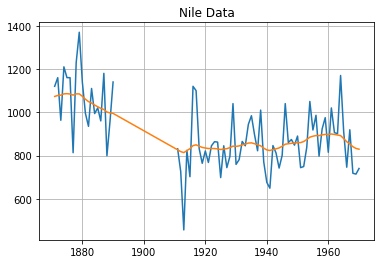

In [251]:
fig, ax = plt.subplots()
data=torch.squeeze(y)
ax.plot(range(1871, 1871 + len(data)), data)
#ax.plot(range(1871, 1871 + len(nile_data)), torch.squeeze(att).numpy())
ax.plot(range(1871, 1871 + len(data)), torch.squeeze(a_hat).numpy())
ax.grid()
ax.set_title('Nile Data')

In [244]:
a_hat

tensor([[[1070.5932, 1084.5415, 1087.9245, 1108.7987, 1115.5034, 1115.9778,
          1110.2885, 1146.2238, 1170.4293, 1166.6921, 1166.6921, 1166.6921,
          1166.6921, 1166.6921, 1166.6921, 1166.6921, 1166.6921, 1166.6921,
          1166.6921, 1166.6921, 1149.2623, 1154.8414, 1152.6976, 1150.9314,
          1135.2943, 1102.1965, 1052.6045, 1006.1775,  946.6140,  911.2190,
           885.7956,  862.0238,  861.7777,  850.5794,  841.8425,  852.8255,
           854.9632,  879.9181,  885.2595,  867.5349,  835.6036,  804.3170,
           783.9959,  809.5989,  833.1855,  875.1400,  882.8106,  860.0715,
           841.2629,  833.2721,  826.9997,  828.9880,  828.7345,  823.5432,
           812.9675,  818.4889,  820.2983,  832.7906,  850.4341,  841.5357,
           844.1934,  855.6991,  865.9026,  879.0328,  883.0665,  872.9682,
           859.5051,  851.2932,  820.8600,  797.4080,  790.9549,  804.3775,
           811.9723,  819.5632,  838.0141,  861.6476,  860.3091,  859.0139,
           8

# Local Linear Trend Model

In [31]:
"""
y_t       = alpha_t + epsilon_t         w/ eps ~ N(0, var_eps)
alpha_t+1 = alpha_t + v_t + eta_t       w/ eta ~ N(0, var_eta)
v_t+1     = v_t + ksi_t                 w/ ksi ~ N(0, var_ksi)
"""

### Want all tensors to be of shape [dimension, 1/dimension ,n]
dtype=torch.float64

# load data, shape [s, n]
nile_data = pd.read_csv(nile_path).values * 0
Tn=100
nile_data = np.zeros((Tn,1))
nile_data[0] = 100

np.random.seed(0)

trend = np.zeros(Tn)
for i in range(1, len(trend)):
    trend[i] = trend[i-1] +  5 * np.random.randn()

level = np.zeros(Tn)
for i in range(1, len(trend)):
    level[i] = level[i-1] + trend[i-1] +  3 * np.random.randn()

for i in range(len(nile_data)):
    nile_data[i] = level[i] + 100 * np.random.randn()
       
y = torch.Tensor(nile_data).type(dtype).t()

# get data into shape [s, 1, n]
y = y[:, None, :]

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = torch.Tensor([[1, 1], [0, 1]]).type(dtype)
Z = torch.Tensor([[1, 0]]).type(dtype)
R = torch.Tensor([[1, 0], [0, 1]]).type(dtype)
Q = torch.Tensor([[1, 0], [0, 1]]).type(dtype)
H = torch.Tensor([[1]]).type(dtype)
diffuse = True

dict_param_llt = {
    0: ("Q", (0, 0, 0), True),
    1: ("Q", (1, 1, 0), True),
    2: ("H", (0, 0, 0), True)
}

llt_params_ini = np.array([3, 5, 100])

T, Z, R, Q, H = _map_vector_to_matrices(llt_params_ini, dict_param_llt, T, Z, R, Q, H)
    
# set options for minimization
options = {
    'eps': 1e-7,
    'disp': True
}

# since estimating variances, must be greater than 0
bnds = ((0.1,  None), (0.1, None), (0.1, None))

# maximize log-likelihook
res = minimize(log_likelihood, llt_params_ini, args=(T, Z, R, Q, H, y, dict_param_llt, diffuse), method='L-BFGS-B', options=options, bounds=bnds)             

llt_params_ini = np.array([3, 5, 100])
T, Z, R, Q, H = _map_vector_to_matrices(res.x, dict_param_llt, T, Z, R, Q, H)
T, Z, R, Q, H = _map_vector_to_matrices(llt_params_ini, dict_param_llt, T, Z, R, Q, H)

a, att, P, Ptt, F, v, K, M  = kalman_filter(T, Z, R, Q, H, y, diffuse=True)
a_hat, r, L, T_ = kalman_smoother(T, Z, R, Q, H, a, P, v, F, K)

llik = log_likelihood(res.x, T, Z, R, Q, H, y, dict_param_llt, True)

Text(0.5, 1.0, 'Level')

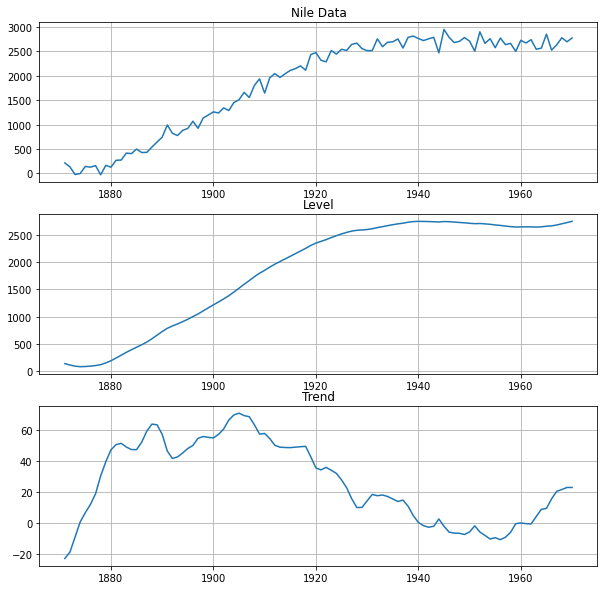

In [33]:
level = np.squeeze(att[0, :, :].numpy())
trend = np.squeeze(att[1, :, :].numpy())
sm_level = np.squeeze(a_hat[0, :, :].numpy())
sm_trend = np.squeeze(a_hat[1, :, :].numpy())

fig, ax = plt.subplots(3)

fig.set_size_inches(10,10)
ax[0].plot(range(1871, 1871 + len(nile_data)), nile_data)
ax[0].plot(range(1871, 1871 + len(nile_data)), level, '')
ax[0].grid()
ax[0].set_title('Nile Data')

ax[2].plot(range(1871, 1871 + len(nile_data)), sm_trend)
ax[2].grid()
ax[2].set_title('Trend')

ax[1].plot(range(1871, 1871 + len(nile_data)), sm_level)
ax[1].grid()
ax[1].set_title('Level')

# Local Linear Trend w/ Weekly seasonal

In [24]:
"""
y_t       = alpha_t + epsilon_t         w/ eps ~ N(0, var_eps)
alpha_t+1 = alpha_t + v_t + eta_t       w/ eta ~ N(0, var_eta)
v_t+1     = v_t + ksi_t                 w/ ksi ~ N(0, var_ksi)
"""

TEST_MISSING = False

### Want all tensors to be of shape [dimension, 1/dimension ,n]
dtype=torch.float64

# load data, shape [s, n]
nile_data = pd.read_csv(nile_path).values * 0
Tn=200
nile_data = np.zeros((Tn,1))
nile_data[0] = 100

# Initializing a queue
days = deque()
for i in range(7):
    days.append(50*np.random.randn())

var_season = 2
var_trend = 10
var_level = 10
var_obs = 20

seasonality = np.zeros(Tn)
for i in range(1, Tn):
    days.popleft()
    seasonality[i] = -sum(days) +  var_season * i * np.random.randn()
    days.append(seasonality[i])

trend = np.zeros(Tn)
for i in range(1, len(trend)):
    trend[i] = trend[i-1] +  var_trend * np.random.randn()

level = np.zeros(Tn)
for i in range(1, len(trend)):
    level[i] = level[i-1] + trend[i-1] +  var_level * np.random.randn()

for i in range(1, len(nile_data)):
    nile_data[i] = level[i] + seasonality[i] + var_obs * np.random.randn()

nile_data[0] = 100

if TEST_MISSING:
    nile_data[60:80] = torch.nan

y = torch.Tensor(nile_data).type(dtype).t()

# get data into shape [s, 1, n]
y = y[:, None, :]

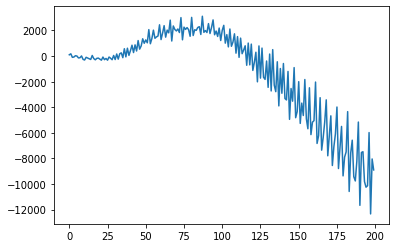

In [26]:
plt.plot(nile_data)

In [25]:
# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = torch.Tensor([[1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, -1, -1, -1, -1, -1, -1], [0, 0, 1, 0, 0, 0, 0, 0]
                  , [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0]]).type(dtype)
Z = torch.Tensor([[1, 0, 1, 0, 0, 0, 0, 0]]).type(dtype)
R = torch.Tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0], 
                  [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]).type(dtype)
Q = torch.Tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).type(dtype)
H = torch.Tensor([[1]]).type(dtype)
diffuse = True

dict_param_llts = {
    0: ("Q", (0, 0, 0), True),
    1: ("Q", (1, 1, 0), True),
    2: ("Q", (2, 2, 0), True),
    3: ("H", (0, 0, 0), True)
}

llts_params_ini = np.array([1, 1, 1, 1])

T, Z, R, Q, H = _map_vector_to_matrices(llts_params_ini, dict_param_llts, T, Z, R, Q, H)
    
# set options for minimization
options = {
    'eps': 1e-7,
    'disp': True
}

# since estimating variances, must be greater than 0
bnds = ((0.1,  None), (0.1, None), (0.1, None), (0.1, None))

# maximize log-likelihook
res = minimize(log_likelihood, llts_params_ini, args=(T, Z, R, Q, H, y, dict_param_llts, diffuse), method='L-BFGS-B', options=options, bounds=bnds)             
print(res.x)

T, Z, R, Q, H = _map_vector_to_matrices(res.x, dict_param_llts, T, Z, R, Q, H)

a, att, P, Ptt, F, v, K, M  = kalman_filter(T, Z, R, Q, H, y, diffuse=True)
a_hat, r, L, T_ = kalman_smoother(T, Z, R, Q, H, a, P, v, F, K)

[1.00000000e-01 8.61498142e+01 5.50113644e+04 1.00000000e-01]


In [27]:
forecast_window=30
a_forecast, P_forecast = kalman_forecast(T, Z, R, Q, H, att, Ptt, time=forecast_window)
nans = torch.ones((1,1, forecast_window)) * torch.nan
y = torch.cat((y, nans), dim=2)
y = np.squeeze(y.numpy())

level_and_season = att[0, :, :] + att[2, :, :]
nans = torch.ones((1, forecast_window)) * torch.nan
level_and_season = torch.cat((level_and_season, nans), dim=1)
level_and_season = np.squeeze(level_and_season.numpy())

history_window=Tn
nans = torch.ones((1, history_window)) * torch.nan
forecast = a_forecast[0, :, :] + a_forecast[2, :, :]
forecast = torch.cat((nans, forecast), dim=1)
forecast = np.squeeze(forecast.numpy())

Text(0.5, 1.0, 'Seasonal')

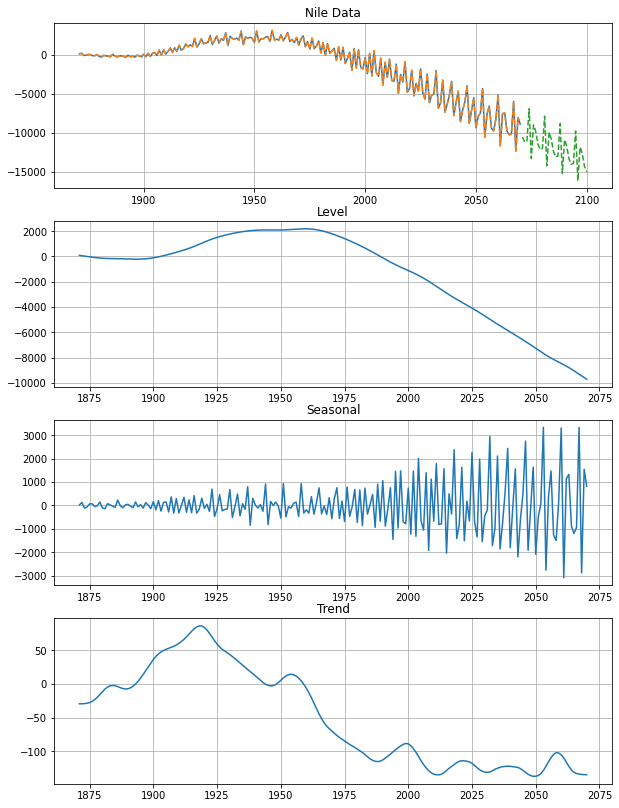

In [29]:
level = np.squeeze(att[0, :, :].numpy())
trend = np.squeeze(att[1, :, :].numpy())

sm_level = np.squeeze(a_hat[0, :, :].numpy())
sm_trend = np.squeeze(a_hat[1, :, :].numpy())
sm_season = np.squeeze(a_hat[2, :, :].numpy())

num_plots = 4
fig, ax = plt.subplots(num_plots)
fig.set_size_inches(10,3.5 * num_plots)

ax[0].plot(range(1871, 1871 + len(y)), y)
ax[0].plot(range(1871, 1871 + len(y)), level_and_season, '--')
ax[0].plot(range(1871, 1871 + len(y)), forecast, '--')
ax[0].grid()
ax[0].set_title('Nile Data')

ax[3].plot(range(1871, 1871 + len(nile_data)), sm_trend)
ax[3].grid()
ax[3].set_title('Trend')

ax[1].plot(range(1871, 1871 + len(nile_data)), sm_level)
ax[1].grid()
ax[1].set_title('Level')

ax[2].plot(range(1871, 1871 + len(nile_data)), sm_season)
ax[2].grid()
ax[2].set_title('Seasonal')

# Log Likelihood test

In [136]:
# loglik test #1
y_test = torch.ones(2,1,100)
F = torch.ones(2,2,100)
for i in range(100):
    F[:, :, i] = torch.eye(2,2)
y_test = torch.ones(2,1,100)
v_test = torch.ones(2,1,100)

# number of observations
n =  int(y_test.shape[2])

# dimension of observation vector
s = int(y_test.shape[0])

# get elementwise log determinants log|F|
F_logdets = torch.logdet(F.permute(2, 0, 1))
#print(torch.sum(F_logdets))
#print(F_logdets.shape)

# get elementwise v'F^(-1)v, then convert shape from [100, 1, 1] -> [100]
vFv = torch.squeeze(_bmm3(v_test.permute(2, 1, 0), torch.inverse(F.permute(2, 0, 1)), v_test.permute(2, 0, 1)))
#print(torch.sum(vFv))

# constant value 
const = s * np.log(2 * np.pi) * torch.ones_like(vFv)
    
# compute log-likelihood
llik = -(1/2) * torch.sum(const + vFv + F_logdets) 

# test -> see notes for calculation
assert round(llik.item(),0) == -284.0 

print('Test completed succesfully! ')

Test completed succesfully! 
